In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing Libraries

In [2]:
# Data Analysis
import pandas as pd
import numpy as np
from pandas import to_datetime

# Data Visualization
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
#importing for arima
from statsmodels.tsa.arima.model import ARIMA
#importing for sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX
#importing for prophet
from prophet import Prophet


# Machine Learning
from sklearn.metrics import mean_squared_error

Data Reading
-----------------------------

In [3]:
# Reading the file
df = pd.read_csv('/content/drive/MyDrive/Datasets/100_THESIS_FINAL/Water Level/NTWL/Rajshahi-Padma.csv')
#the daily dataset
print(df.shape)
df.head()

(20444, 2)


,Date,WL(m)
0,1961-04-01,11.25
1,1961-04-02,11.23
2,1961-04-03,11.21
3,1961-04-04,11.19
4,1961-04-05,11.17


In [4]:
#checking types
df.dtypes

Date      object
WL(m)    float64
dtype: object

Data Preprocessing
---------

In [5]:
# 1. Checking missing values
df.isnull().sum()
# 2.Dropping nulls
print(df.dropna())

             Date   WL(m)
0      1961-04-01  11.250
1      1961-04-02  11.230
2      1961-04-03  11.210
3      1961-04-04  11.190
4      1961-04-05  11.170
...           ...     ...
20439  2019-04-26   8.920
20440  2019-04-27   8.890
20441  2019-04-28   9.016
20442  2019-04-29   9.050
20443  2019-04-30   9.050

[20444 rows x 2 columns]


In [6]:
# 3.Check for duplicates
df.duplicated().sum()

0

In [7]:
df.head()

,Date,WL(m)
0,1961-04-01,11.25
1,1961-04-02,11.23
2,1961-04-03,11.21
3,1961-04-04,11.19
4,1961-04-05,11.17


In [8]:
df.tail()

,Date,WL(m)
20439,2019-04-26,8.920
20440,2019-04-27,8.890
20441,2019-04-28,9.016
20442,2019-04-29,9.050
20443,2019-04-30,9.050


In [9]:
# Preparing dataset for forecasting
df_pr = df
# 4.sorting dataset by date for forecast
df_pr.sort_values('Date', inplace=True)
# 5.setting the index by date after sorting
df_pr.set_index('Date', inplace=True)
df_pr.head()

,WL(m)
Date,
1961-04-01,11.25
1961-04-02,11.23
1961-04-03,11.21
1961-04-04,11.19
1961-04-05,11.17


In [10]:
# 6.Resampling dataset to monthly timeseries
df_pr.index = pd.to_datetime(df_pr.index)
monthly = df_pr.resample('M').mean()
print(monthly.shape)
monthly.head()
monthly.to_csv("Rajshahi-Padma_monthly.csv")

(697, 1)


In [11]:
# Understanding the data for TS
print(f'Start Date: {monthly.index.min()}')
print(f'End Date: {monthly.index.max()}')
print(f'Total month: {len(monthly)}')
print(f'Total year: {int(len(monthly.index)/12)}')

Start Date: 1961-04-30 00:00:00
End Date: 2019-04-30 00:00:00
Total month: 697
Total year: 58


Data Visulalization
----------

About Data

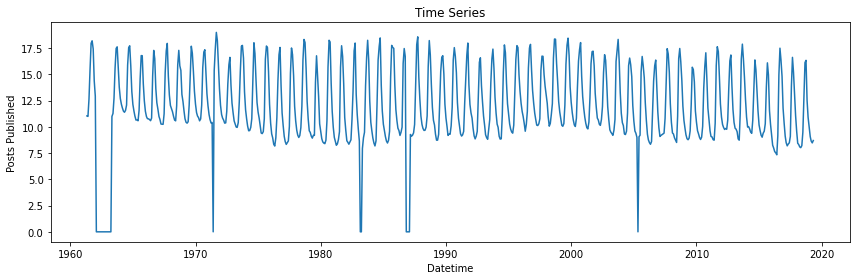

In [12]:
# 7.Plotting the time series
monthly['WL(m)'] = monthly['WL(m)'].fillna(0)
plt.figure(figsize=(12, 4))
plt.plot(monthly)
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Time Series')
plt.tight_layout()
plt.show()

Splitting the Train & Test data for forecasting

Shape: Train=(585, 1), Validation=(112, 1)


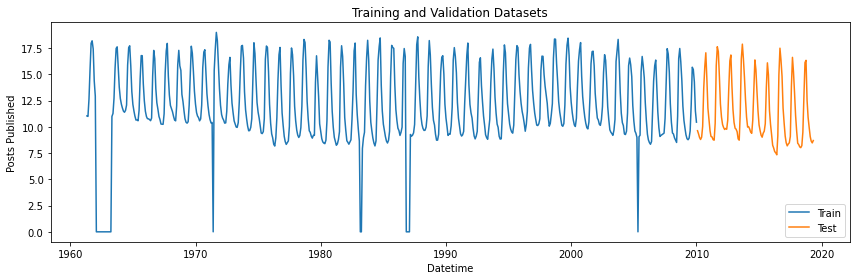

In [13]:
train = monthly.loc[:'2009-12-31']
valid = monthly.loc['2010-01-31':]
print(f'Shape: Train={train.shape}, Validation={valid.shape}')

# Plotting the training and validation datasets
plt.figure(figsize=(12, 4))
plt.plot(train, label='Train')
plt.plot(valid, label='Test')
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Training and Validation Datasets')
plt.legend()
plt.tight_layout()
plt.show()

Indexing the train and test data into date form

In [14]:
train.index = pd.DatetimeIndex(train.index)
valid.index = pd.DatetimeIndex(valid.index)

In [15]:
# Visualizing the components of time series: Trend, Seasonality, and Noise
train.sort_index(inplace=True)
decomposition = sm.tsa.seasonal_decompose(train.dropna(), model = 'additive', period = int(len(train)/4))

Time series decomposition is a technique that splits a time series into several components, each representing an underlying pattern category,trend, seasonality and noise.

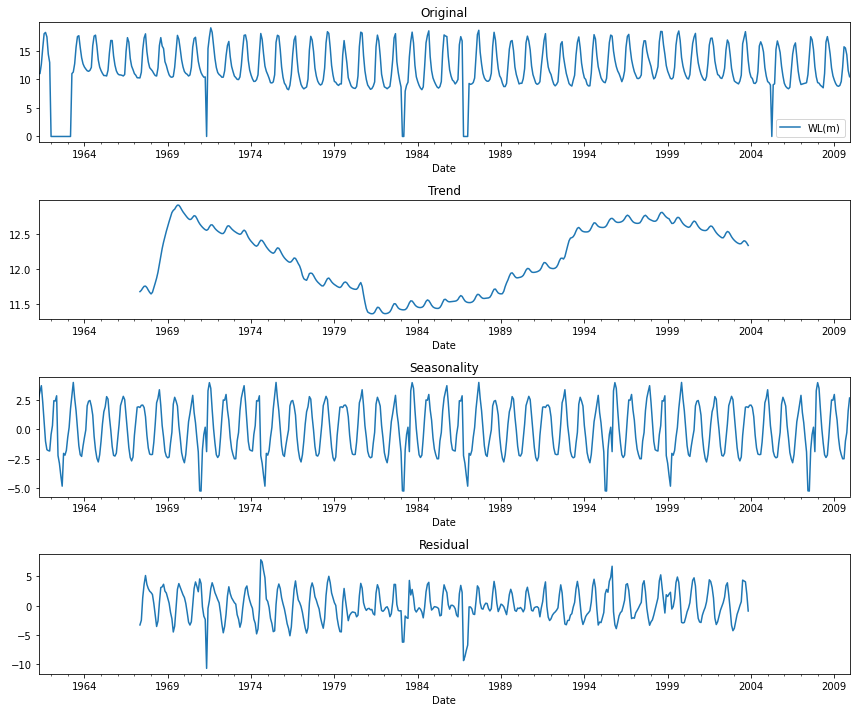

In [16]:
# Plotting the components
fig, axes = plt.subplots(4, 1, figsize=(12, 10)) 
train.plot(title='Original', ax=axes[0])
decomposition.trend.plot(title='Trend', ax=axes[1])
decomposition.seasonal.plot(title='Seasonality', ax=axes[2])
decomposition.resid.plot(title='Residual', ax=axes[3])
plt.tight_layout()
plt.show()

In [17]:
# Creating a function to plot the results of the forecast
def plot_forecast(forecast, model, rmse):
    plt.figure(figsize=(12,4))
    plt.plot(train.dropna(), label='Training')
    plt.plot(valid.dropna(), label='Actual')
    plt.plot(forecast, label='Forecast')
    plt.xlabel('Datetime')
    plt.ylabel('Posts Published')
    plt.title(f'{model} (RMSE: {round(rmse, 2)})')
    plt.legend()
    plt.tight_layout()
    plt.show()

Checking Seasonality of TS DATA
------------

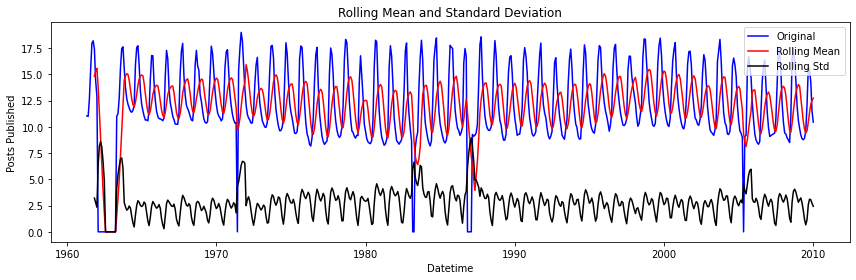

Results of Dickey-Fuller Test:
Test Statistic                -7.489728e+00
P-Value                        4.539032e-11
#Lags Used                     1.400000e+01
Number of Observations Used    5.700000e+02
Critical Value (1%)           -3.441875e+00
Critical Value (5%)           -2.866624e+00
Critical Value (10%)          -2.569478e+00
dtype: float64


In [18]:
# Creating a function to check stationarity of the train data
def check_stationarity(data):
    # Determining rolling statistics
    rol_mean = data.rolling(7).mean() #7 days in a week
    rol_std = data.rolling(7).std()
    
    # Plotting rolling statistics
    plt.figure(figsize=(12, 4))
    plt.plot(data, color='blue', label='Original')
    plt.plot(rol_mean, color='red', label='Rolling Mean')
    plt.plot(rol_std, color='black', label='Rolling Std')
    plt.xlabel('Datetime')
    plt.ylabel('Posts Published')
    plt.title('Rolling Mean and Standard Deviation')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Performing Dickey-Fuller test
    results = adfuller(data)
    df_output = pd.Series(results[:4], index=['Test Statistic', 'P-Value', '#Lags Used', 'Number of Observations Used'])
    for key, value in results[4].items():
        df_output[f'Critical Value ({key})'] = value
    print(f'Results of Dickey-Fuller Test:\n{df_output}')
    
# Stationarity check of our daily time series
check_stationarity(train)

###### As the test statistic is less than the critical values, we can say that the time series is already stationary. We can also see a trend in the visualization, therefore, we dont need to remove the trend and seasonality.

TIME SERIES MODELS
-----

ARIMA MODEL 

In [19]:
#MODEL implement and order set
arima = ARIMA(train, order=(7,1,1))

In [20]:
#model Fit
arima_model_fit = arima.fit()
# print summary of fit model
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  WL(m)   No. Observations:                  585
Model:                 ARIMA(7, 1, 1)   Log Likelihood               -1207.845
Date:                Sun, 06 Nov 2022   AIC                           2433.691
Time:                        18:27:14   BIC                           2473.020
Sample:                    04-30-1961   HQIC                          2449.019
                         - 12-31-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7319      0.053     13.894      0.000       0.629       0.835
ar.L2         -0.1287      0.043     -3.003      0.003      -0.213      -0.045
ar.L3         -0.2439      0.039     -6.279      0.0

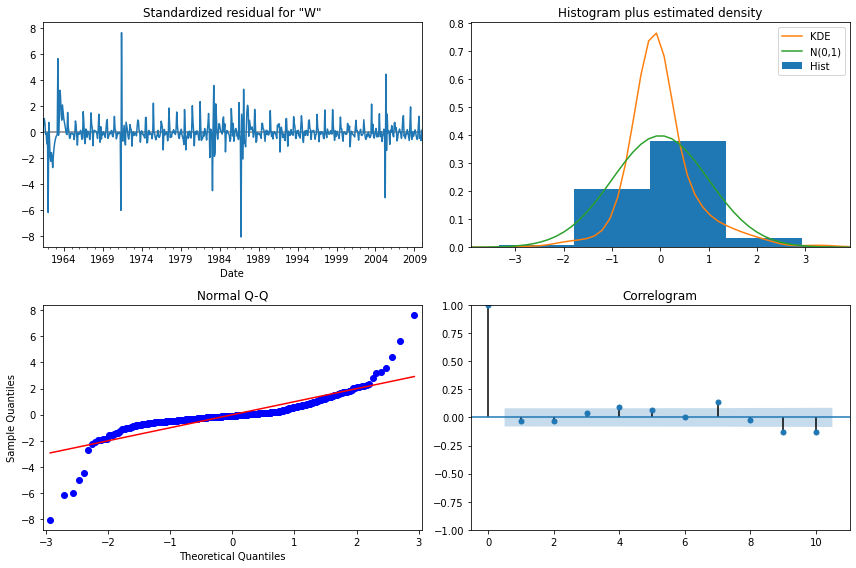

In [21]:
# Residual Plots
arima_model_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

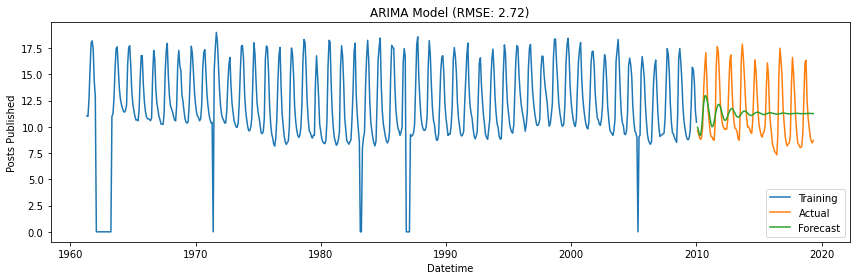

In [22]:
# Forecasting with the ARIMA model
forecast_arima = arima_model_fit.forecast(steps=len(valid))
arima_rmse = mean_squared_error(valid, forecast_arima, squared=False)
# # Plotting the ARIMA forecast
plot_forecast(forecast_arima, 'ARIMA Model', arima_rmse)

In [23]:
#Values of ARIMA prediction
print(forecast_arima)

2010-01-31     9.953652
2010-02-28     9.637042
2010-03-31     9.223178
2010-04-30     9.210098
2010-05-31     9.852784
                ...    
2018-12-31    11.277774
2019-01-31    11.276322
2019-02-28    11.272835
2019-03-31    11.268357
2019-04-30    11.264070
Freq: M, Name: predicted_mean, Length: 112, dtype: float64


In [24]:
arima_rmse  = mean_squared_error(valid, forecast_arima,squared=False)
print('Arima Root Mean Squared Error: ',arima_rmse)

Arima Root Mean Squared Error:  2.7222779853793027


---------------------

SARIMAX MODEL

In [25]:
#SARIMAX model order set
#(7,2,1, 12)
my_seasonal_order = (7,1,1, 12)
sarimax = SARIMAX(train, order=(7,1,1),seasonal_order=my_seasonal_order)

In [26]:
#Model fit
sarimax_model_fit = sarimax.fit()
# print summary of fit model
print(sarimax_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              WL(m)   No. Observations:                  585
Model:             SARIMAX(7, 1, 1)x(7, 1, 1, 12)   Log Likelihood               -1072.717
Date:                            Sun, 06 Nov 2022   AIC                           2179.435
Time:                                    18:29:41   BIC                           2253.370
Sample:                                04-30-1961   HQIC                          2208.278
                                     - 12-31-2009                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3507      4.607     -0.076      0.939      -9.380       8.679
ar.L2         -0.1366      1.076   

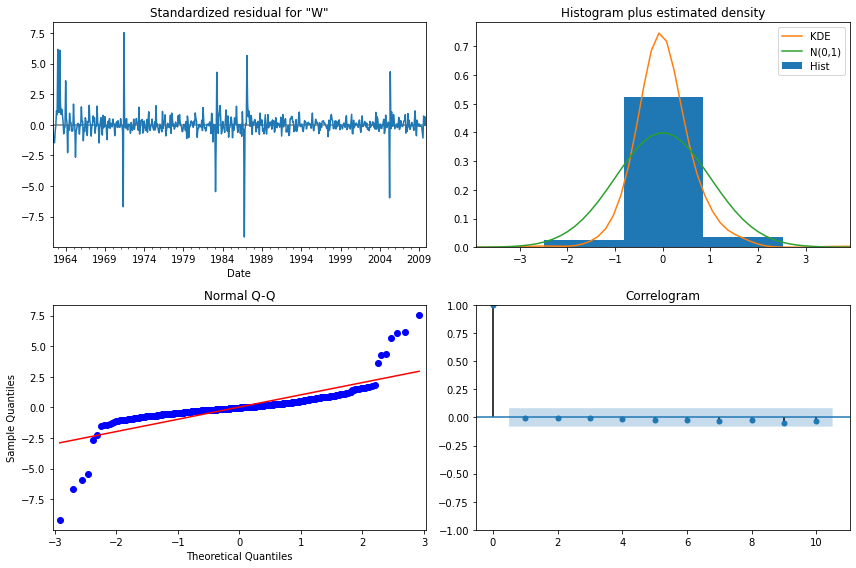

In [27]:
# Residual Plots
sarimax_model_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

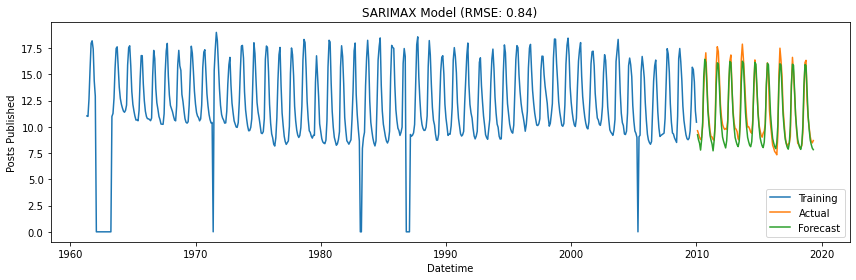

In [28]:
# Forecasting with the SARIMAX model
forecast_sarimax = sarimax_model_fit.forecast(steps=len(valid))
sarimax_rmse = mean_squared_error(valid, forecast_sarimax, squared=False)
# # Plotting the SARIMAX forecast
plot_forecast(forecast_sarimax, 'SARIMAX Model', sarimax_rmse)

In [29]:
#Value of SARIMA prediction
print(forecast_sarimax)

2010-01-31    9.243438
2010-02-28    8.772765
2010-03-31    8.444208
2010-04-30    7.789289
2010-05-31    8.777740
                ...   
2018-12-31    9.772339
2019-01-31    8.745467
2019-02-28    8.339356
2019-03-31    7.978152
2019-04-30    7.827518
Freq: M, Name: predicted_mean, Length: 112, dtype: float64


In [30]:
sarimax_rmse = mean_squared_error(valid, forecast_sarimax, squared=False)
print('Sarimax Root Mean Squared Error: ',sarimax_rmse)

Sarimax Root Mean Squared Error:  0.8397998203625033


-----------------------

PROPHET

In [31]:
#Reading monthly data 
df= pd.read_csv('Rajshahi-Padma_monthly.csv')

In [32]:
#renaming column for formatting prophet
df.columns = ['ds','y']
df.head()

,ds,y
0,1961-04-30,11.042333
1,1961-05-31,10.993226
2,1961-06-30,12.645667
3,1961-07-31,15.476774
4,1961-08-31,17.965161


In [33]:
#prophet model Implement
prophet_model = Prophet()

In [34]:
#Model fit
fit=prophet_model.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpet2f47zc/wpnixb1y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpet2f47zc/ge99iqzd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70115', 'data', 'file=/tmp/tmpet2f47zc/wpnixb1y.json', 'init=/tmp/tmpet2f47zc/ge99iqzd.json', 'output', 'file=/tmp/tmpet2f47zc/prophet_modelv_yy6pjx/prophet_model-20221106182944.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [35]:
#forecasting the next 5 years monthly data
prophet_forecast_date = prophet_model.make_future_dataframe(periods=12 * 6, freq='M')
print(prophet_forecast_date)

            ds
0   1961-04-30
1   1961-05-31
2   1961-06-30
3   1961-07-31
4   1961-08-31
..         ...
764 2024-12-31
765 2025-01-31
766 2025-02-28
767 2025-03-31
768 2025-04-30

[769 rows x 1 columns]


In [36]:
#Prediting for the previous and next 5 years
prophet_prediction=prophet_model.predict(prophet_forecast_date)
prophet_prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1961-04-30,13.672404,9.842882,11.668818,13.672404,13.672404,-2.932162,-2.932162,-2.932162,-2.932162,-2.932162,-2.932162,0.0,0.0,0.0,10.740242
1,1961-05-31,13.664308,10.054201,11.942614,13.664308,13.664308,-2.659923,-2.659923,-2.659923,-2.659923,-2.659923,-2.659923,0.0,0.0,0.0,11.004385
2,1961-06-30,13.656473,11.540908,13.370199,13.656473,13.656473,-1.155578,-1.155578,-1.155578,-1.155578,-1.155578,-1.155578,0.0,0.0,0.0,12.500895
3,1961-07-31,13.648376,15.575480,17.423911,13.648376,13.648376,2.840683,2.840683,2.840683,2.840683,2.840683,2.840683,0.0,0.0,0.0,16.489060
4,1961-08-31,13.640280,17.586477,19.472340,13.640280,13.640280,4.924474,4.924474,4.924474,4.924474,4.924474,4.924474,0.0,0.0,0.0,18.564754


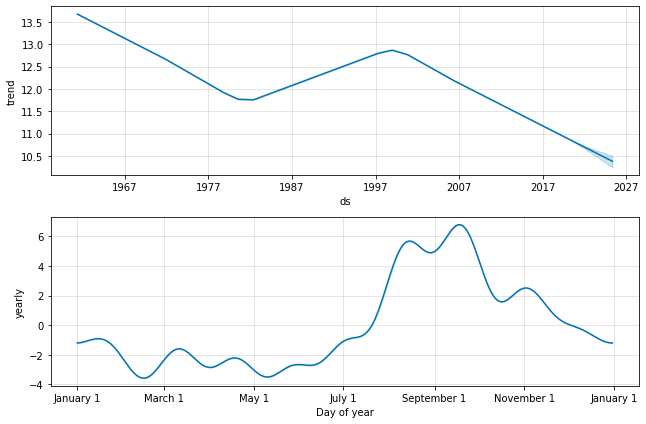

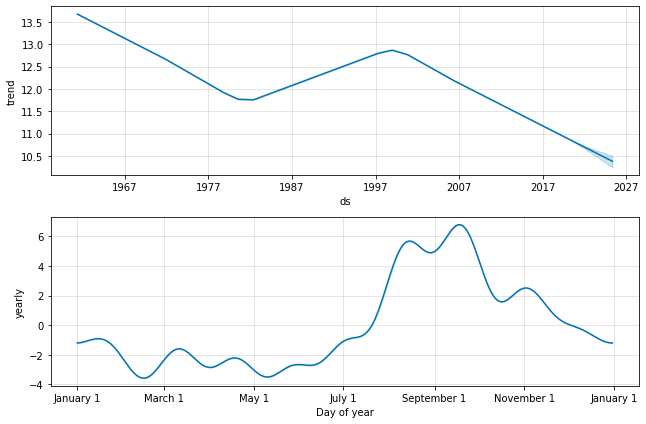

In [37]:
#### Visualize Each Components[Trends,yearly]
prophet_model.plot_components(prophet_prediction)

In [38]:
forecast_prophet_data=pd.DataFrame(prophet_prediction,columns=['ds','yhat'])
#setting the date as index of the dataframe 
fd=forecast_prophet_data.set_index('ds')
print(fd)

                 yhat
ds                   
1961-04-30  10.740242
1961-05-31  11.004385
1961-06-30  12.500895
1961-07-31  16.489060
1961-08-31  18.564754
...               ...
2024-12-31   9.209389
2025-01-31   8.287491
2025-02-28   7.923694
2025-03-31   7.549423
2025-04-30   7.450483

[769 rows x 1 columns]


In [39]:
#converting the dataframe into series
full_forecast_prophet=fd['yhat'].squeeze()
print(full_forecast_prophet)

ds
1961-04-30    10.740242
1961-05-31    11.004385
1961-06-30    12.500895
1961-07-31    16.489060
1961-08-31    18.564754
                ...    
2024-12-31     9.209389
2025-01-31     8.287491
2025-02-28     7.923694
2025-03-31     7.549423
2025-04-30     7.450483
Name: yhat, Length: 769, dtype: float64


In [40]:
print(valid)

               WL(m)
Date                
2010-01-31  9.633548
2010-02-28  9.348929
2010-03-31  8.987097
2010-04-30  8.797333
2010-05-31  9.019935
...              ...
2018-12-31  9.950194
2019-01-31  9.070452
2019-02-28  8.643214
2019-03-31  8.472516
2019-04-30  8.698067

[112 rows x 1 columns]


In [41]:
forecast_prophet_valid=full_forecast_prophet['2010-01-31':'2019-04-30']

In [42]:
prophet_rmse = mean_squared_error(valid,forecast_prophet_valid, squared=False)
print('Prophet Root-mean-square error: ',prophet_rmse)

Prophet Root-mean-square error:  0.6974562271313143


-----------------

MODEL Comparison
----------

Testing

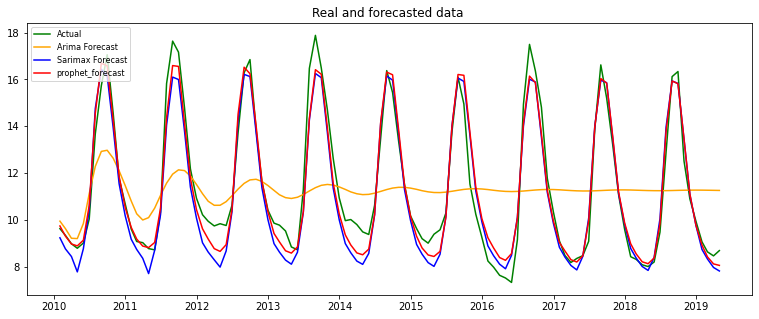

In [43]:
#comparing with test(actual) data
plt.figure(figsize=(13, 5))
# plot Testing and Forecasted data
plt.title("Real and forecasted data ")
plt.plot(valid, label='Actual', color='green')
plt.plot(forecast_arima, label='Arima Forecast', color='orange')
plt.plot(forecast_sarimax, label='Sarimax Forecast', color='blue')
plt.plot(forecast_prophet_valid, label='prophet_forecast', color='red')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Forecasting for 15 years since  2010 to 2025

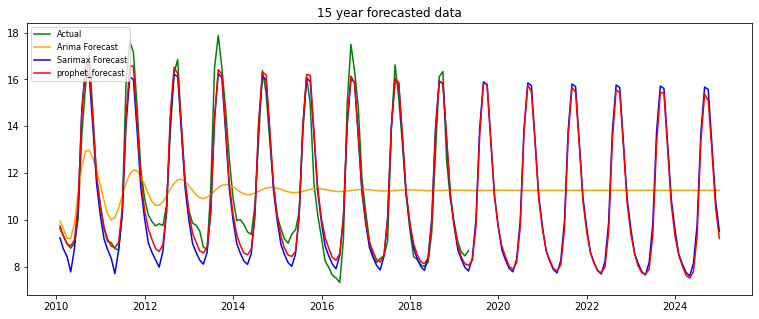

In [44]:
forecast_10_arima = arima_model_fit.forecast(steps=len(valid)+68)
forecast_10_sarima = sarimax_model_fit.forecast(steps=len(valid)+68)
forecast_10_prophet=full_forecast_prophet['2010-01-31':'2024-12-31']
plt.figure(figsize=(13, 5))
# plot Testing and Forecasted data
plt.title("15 year forecasted data")
plt.plot(valid, label='Actual', color='green')
plt.plot(forecast_10_arima, label='Arima Forecast', color='orange')
plt.plot(forecast_10_sarima, label='Sarimax Forecast', color='blue')
plt.plot(forecast_10_prophet, label='prophet_forecast', color='red')
plt.legend(loc='upper left', fontsize=8)
plt.show()

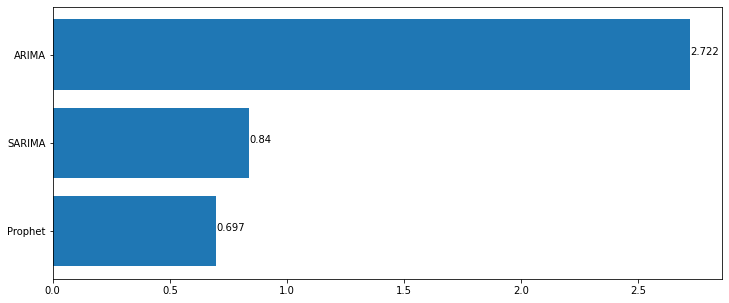

In [45]:
# Comparing Model Performances
plt.figure(figsize=(12, 5))
perf = pd.DataFrame({'Model': ['ARIMA', 'SARIMA', 'Prophet'],
                     'RMSE': [arima_rmse, sarimax_rmse, prophet_rmse]})
perf.sort_values('RMSE', inplace=True)
plt.barh(perf.Model, perf.RMSE)
 
for index,value in enumerate( perf.RMSE):
  final_value=round(value, 3)
  plt.text(value, index,str(final_value))
 
plt.show()

In [46]:
from datetime import date, datetime
print("--Enter the last date of the month between 2010 to 2024 to see the forecasted value--")
Date= (input('Enter a date in yyyy-mm-dd format :'))
print("")
if Date in forecast_10_arima.index or Date in forecast_10_sarima or Date in forecast_10_prophet:
  print("Great! Now choose the model result you want to see for",Date)
  model=int(input(' 1.Arima \n 2.Sarimax\n 3.Prophet\n '))
  if model==1:
    print("Choosen Model is Arima")
    print("In",Date,"rainfall value for Arima model: ",forecast_10_arima[Date])
  elif model==2:
    print("Choosen Model is Sarimax")
    print("In",Date,"rainfall value for Sarimax model: ",forecast_10_sarima[Date])
  elif model==3:
    print("Choosen Model is prophet")
    print("In",Date,"rainfall value for Prophet model: ",forecast_10_prophet[Date])
  else:
    print("choose among the three model")
else:
  print("Choose the correct date according to the mentioned format")


--Enter the last date of the month between 2010 to 2024 to see the forecasted value--
Enter a date in yyyy-mm-dd format :2020-09-30

Great! Now choose the model result you want to see for 2020-09-30
 1.Arima 
 2.Sarimax
 3.Prophet
 2
Choosen Model is Sarimax
In 2020-09-30 rainfall value for Sarimax model:  15.739392626915787


In [47]:
merged=pd.concat([forecast_10_arima,forecast_10_sarima,forecast_10_prophet])
merged.to_csv("Rajshahi-Padma-monthly_merged.csv")